In [1]:
%load_ext autoreload
%autoreload 2

Device:  cuda:0
255


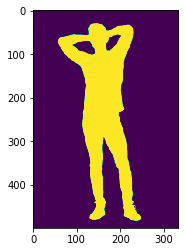

In [15]:
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

folder = '/home/ysheng/Dataset/soft_shadow/real_human_testing_set/'
files =  [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

for f in files:
    img = np.array(Image.open(os.path.join(folder, f)))
    plt.figure()
    plt.imshow(img[:,:,3])
    print(np.max(img[:,:,3]))
    plt.show()
    break

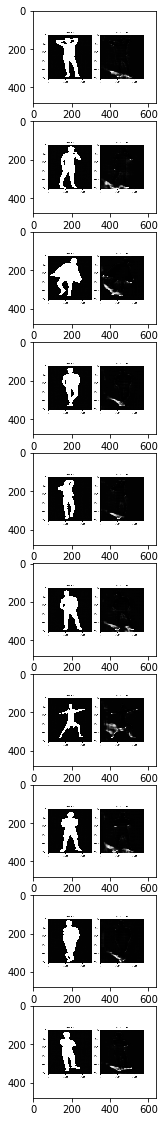

In [26]:
from result_visualize import visualize_folder
visualize_folder('results')

In [20]:
from valid_relight_ssn import predict_results

predict_results('/home/ysheng/Dataset/soft_shadow/real_human_testing_set/','')

Predict 45 files
torch.Size([1, 1, 16, 32])
500_F_147564849_igkwKdwo68M9v31hRfyMTLjuAcEH6N0e.png
/home/ysheng/Dataset/soft_shadow/real_human_testing_set/


FileNotFoundError: [Errno 2] No such file or directory: ''

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import argparse
import time
from tqdm import tqdm
import numpy as np
import os
import math

from ssn.ssn_dataset import SSN_Dataset
# from ssn.ssn_submodule import Contract
from ssn.ssn import Relight_SSN
from utils.net_utils import save_model

from utils.visdom_utils import visdom_plot_loss, visdom_relight_results, visdom_log, visdom_show_batch

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')
print("Device: ", device)

In [ ]:
# data set
train_trnfs, valid_trnfs = transforms.ToTensor(), transforms.ToTensor()

ds_csv = "~/Dataset/soft_shadow/single_human/metadata.csv"
train_set = SSN_Dataset(ds_csv, True, train_trnfs)
train_dataloder = DataLoader(train_set, batch_size=4, shuffle=True, num_workers=4)
valid_set = SSN_Dataset(ds_csv, False, valid_trnfs)
valid_dataloader = DataLoader(valid_set, batch_size=4, shuffle=False, num_workers=4)

In [ ]:
from torchvision.utils import make_grid
    
model = Relight_SSN(2,2)
model.to(device)    

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

""" Load Weight """
# checkpoint_file = 'weights/seperate_loss_02-December-10-19-AM.pt'
# checkpoint = torch.load(checkpoint_file)
# model.load_state_dict(checkpoint['model_state_dict'])

def show(img):
    plt.figure(figsize=(15,10))
    npimg = img.detach().cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

#with torch.no_grad():
    # model.eval()
for i, (mask, light, shadow, nov_mask, nov_light, nov_shadow) in enumerate(train_dataloder):    
    # concatenate human mask and shadow mask
    I_s = torch.cat((mask, shadow), dim=1).to(device)
    L_t = nov_light.to(device)
    I_t = torch.cat((mask, nov_shadow), dim=1).to(device)
    L_s = light.to(device)

    predicted_img, predicted_src_light = model(I_s, L_t)
    predicted_src_img, predicted_src_light = model(I_s, L_s)
    
    print(predicted_src_light.size())
    print(predicted_img.size())
    mask, shadow = predicted_img[:,0,:,:], predicted_img[:,1,:,:]

    # show(make_grid(mask))
    show(make_grid(shadow))

    break

In [ ]:
print(torch.min(shadow))

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

""" Load Weight """
checkpoint_file = 'weights/28-November-12-17-PM.pt'
checkpoint = torch.load(checkpoint_file)
model.load_state_dict(checkpoint['model_state_dict'])

def show(img):
    plt.figure(figsize=(15,10))
    npimg = img.detach().cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

with torch.no_grad():
    model.eval()
    for i, (mask, light, shadow, nov_mask, nov_light, nov_shadow) in enumerate(train_dataloder):
        # concatenate human mask and shadow mask
        I_s = torch.cat((mask, shadow), dim=1).to(device)
        L_t = nov_light.to(device)
        I_t = torch.cat((mask, nov_shadow), dim=1).to(device)
        L_s = light.to(device)

        predicted_img, predicted_src_light = model(I_s, L_t)
        predicted_src_img, predicted_src_light = model(I_s, L_s)

        print(predicted_img.size())
        mask, shadow = predicted_img[:,0:3,:,:],predicted_img[:,3:,:,:]

        # show(make_grid(mask))
        show(make_grid(shadow))

        break